# Latent Class Model Demo: End-to-End Analysis

This notebook demonstrates a complete workflow for latent class modeling of multivariate categorical data:

1. **Data Generation**: Create synthetic data from a known latent class model
2. **Model Selection**: Use BIC to automatically select the optimal number of classes
3. **Model Fitting**: Estimate parameters using the EM algorithm
4. **Results Analysis**: Evaluate model performance and parameter recovery

## Setup and Configuration

First, we'll import the necessary libraries and configure our experiment parameters.

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import sys

# Add parent directory to path to import from src
sys.path.append('..')

# Import our latent class modeling modules
from src.dgp import LatentClassDGP
from src.latent_class_modeling import LatentClassModel
from src.model_selection import BICModelSelector
from src.visualization import (
    plot_bic_curve,
    plot_mixture_weights,
    plot_categorical_probabilities,
    plot_class_assignments,
    plot_posterior_uncertainty
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

### Experiment Configuration

Here we define the key parameters for our synthetic data generation and model fitting:

- **n**: Number of samples to generate
- **K_true**: True number of latent classes in the data
- **m**: Number of categorical variables (features)
- **C**: Number of categories for each variable
- **K_range**: Range of K values to test during BIC model selection

These parameters are configurable - feel free to modify them to explore different scenarios!

In [2]:
# ============================================================================
# CONFIGURABLE PARAMETERS
# ============================================================================

# Data generation parameters
n = 2000           # Number of samples
K_true = 3         # True number of latent classes
m = 20             # Number of variables
C = 3              # Number of categories per variable

# Model selection parameters
K_range = [1, 2, 3, 4, 5, 6]  # Range of K values to test

# EM algorithm parameters
max_iter = 500     # Maximum EM iterations
tol = 1e-6         # Convergence tolerance
n_init = 5         # Number of random initializations

print("Experiment Configuration:")
print("="*50)
print(f"Sample size (n):              {n}")
print(f"True number of classes (K):   {K_true}")
print(f"Number of variables (m):      {m}")
print(f"Categories per variable (C):  {C}")
print(f"K range to test:              {K_range}")
print(f"EM max iterations:            {max_iter}")
print(f"Random initializations:       {n_init}")
print("="*50)

Experiment Configuration:
Sample size (n):              2000
True number of classes (K):   3
Number of variables (m):      20
Categories per variable (C):  3
K range to test:              [1, 2, 3, 4, 5, 6]
EM max iterations:            500
Random initializations:       5


## Step 1: Generate Synthetic Data

We'll generate synthetic data from a latent class model with known parameters. This allows us to evaluate how well our method can recover the true structure.

The generative model is:

$$P(X = x) = \sum_{k=1}^K \pi_k \prod_{r=1}^m P(X^{(r)} = x^{(r)} | H = k)$$

where:
- $\pi_k$ are the mixture weights (class probabilities)
- $\theta_{rkc} = P(X^{(r)} = c | H = k)$ are the categorical probabilities
- $H$ is the latent class variable

In [3]:
# Create data generating process
categories = [C] * m  # All variables have C categories
dgp = LatentClassDGP(K=K_true, categories=categories, random_state=42)

# Generate synthetic data
X, H = dgp.generate_data(n)

# Get true parameters
true_params = dgp.get_true_parameters()
true_pi = true_params['pi']
true_theta = true_params['theta']

print("\n" + "="*70)
print("SYNTHETIC DATA GENERATED")
print("="*70)
print(f"Data shape: {X.shape} (samples × variables)")
print(f"\nTrue mixture weights (π):")
for k in range(K_true):
    print(f"  Class {k}: π_{k} = {true_pi[k]:.4f}")
print(f"\nTrue class distribution in generated data:")
for k in range(K_true):
    count = np.sum(H == k)
    proportion = count / n
    print(f"  Class {k}: {count} samples ({proportion:.1%})")


SYNTHETIC DATA GENERATED
Data shape: (2000, 20) (samples × variables)

True mixture weights (π):
  Class 0: π_0 = 0.3359
  Class 1: π_1 = 0.3342
  Class 2: π_2 = 0.3299

True class distribution in generated data:
  Class 0: 679 samples (34.0%)
  Class 1: 663 samples (33.1%)
  Class 2: 658 samples (32.9%)


### Data Exploration

Let's examine the generated data to understand its structure.

In [4]:
# Convert to DataFrame for easier viewing
df = pd.DataFrame(X, columns=[f'Var_{r}' for r in range(m)])
df['TrueClass'] = H

print("\nFirst 10 rows of generated data:")
print(df.head(10))

print("\nData summary statistics:")
print(df.describe())


First 10 rows of generated data:
   Var_0  Var_1  Var_2  Var_3  Var_4  Var_5  Var_6  Var_7  Var_8  Var_9  ...  \
0      0      1      2      1      0      0      0      1      0      0  ...   
1      0      2      1      1      1      1      0      1      0      1  ...   
2      0      1      0      1      1      1      1      2      1      0  ...   
3      2      1      0      2      1      0      1      0      1      2  ...   
4      1      0      2      2      0      2      1      0      2      1  ...   
5      0      2      1      0      1      2      2      0      2      1  ...   
6      2      0      0      1      0      1      2      0      2      0  ...   
7      1      2      1      1      1      2      1      2      0      1  ...   
8      2      1      2      1      1      2      1      0      0      1  ...   
9      2      1      1      0      0      2      2      1      0      0  ...   

   Var_11  Var_12  Var_13  Var_14  Var_15  Var_16  Var_17  Var_18  Var_19  \
0       

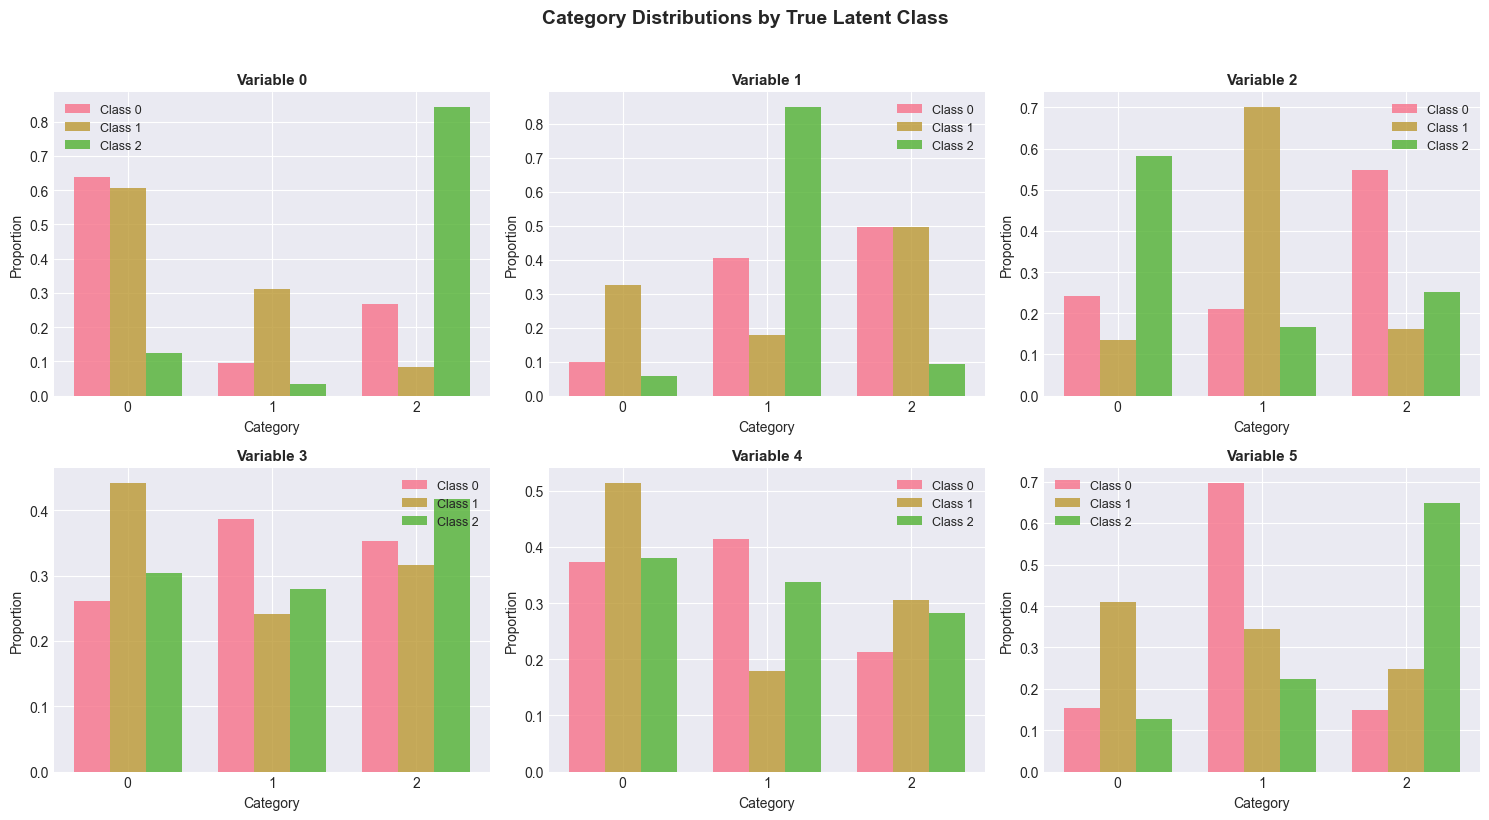


These plots show how different latent classes generate different
category distributions for each variable. The separation between
classes indicates how well they can be identified from the data.


In [5]:
# Visualize the distribution of categories for a few variables
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, var_idx in enumerate([0, 1, 2, 3, 4, 5]):
    ax = axes[idx]
    
    # Count categories by class
    for k in range(K_true):
        mask = H == k
        values = X[mask, var_idx]
        counts = np.bincount(values, minlength=C)
        proportions = counts / counts.sum()
        
        ax.bar(np.arange(C) + k*0.25, proportions, width=0.25, 
               label=f'Class {k}', alpha=0.8)
    
    ax.set_xlabel('Category', fontsize=10)
    ax.set_ylabel('Proportion', fontsize=10)
    ax.set_title(f'Variable {var_idx}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.set_xticks(np.arange(C) + 0.25)
    ax.set_xticklabels(range(C))

plt.suptitle('Category Distributions by True Latent Class', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nThese plots show how different latent classes generate different")
print("category distributions for each variable. The separation between")
print("classes indicates how well they can be identified from the data.")

## Step 2: Model Selection via BIC

We'll use the Bayesian Information Criterion (BIC) to automatically select the optimal number of latent classes. BIC balances model fit with model complexity:

$$\text{BIC} = -2 \cdot \log L(\Theta | X) + p \cdot \log(n)$$

where:
- $L(\Theta | X)$ is the likelihood of the data given the parameters
- $p$ is the number of free parameters
- $n$ is the sample size

Lower BIC values indicate better models. The penalty term ($p \cdot \log(n)$) prevents overfitting by discouraging overly complex models.

In [6]:
print("\n" + "="*70)
print("BIC MODEL SELECTION")
print("="*70)
print(f"Testing K values: {K_range}")
print(f"Each K fitted with {n_init} random initializations")
print("\nThis may take a few minutes...\n")

# Create BIC selector
selector = BICModelSelector(
    K_range=K_range,
    categories=categories,
    max_iter=max_iter,
    tol=tol,
    n_init=n_init,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit models for all K values
selector.fit(X, verbose=True, parallel_strategy='auto')

# Get results
results = selector.get_all_results()
selected_K = selector.best_K

print("\n" + "="*70)
print("MODEL SELECTION RESULTS")
print("="*70)
print(f"Selected K: {selected_K}")
print(f"True K:     {K_true}")

if selected_K == K_true:
    print("\n✓ SUCCESS: Correctly identified the true number of classes!")
else:
    print(f"\n✗ MISMATCH: Selected K={selected_K}, but true K={K_true}")

print("\nBIC values for all tested K:")
for k, bic, loglik in zip(results['K_range'], results['bic_values'], results['log_likelihoods']):
    marker = "<-- SELECTED" if k == selected_K else ""
    true_marker = "(TRUE K)" if k == K_true else ""
    print(f"  K={k}: BIC={bic:10.2f}, Log-lik={loglik:10.2f}  {true_marker}{marker}")


BIC MODEL SELECTION
Testing K values: [1, 2, 3, 4, 5, 6]
Each K fitted with 5 random initializations

This may take a few minutes...

BIC Model Selection: Testing K in [1, 2, 3, 4, 5, 6]
Each K fitted with 5 random initializations
Total available cores: 10
Auto-selected strategy: 6 jobs for K, 1 jobs for inits
Running 6 K values in parallel...

Best K selected: 3 (BIC = 80893.46)
Log-likelihood: -39983.08

MODEL SELECTION RESULTS
Selected K: 3
True K:     3

✓ SUCCESS: Correctly identified the true number of classes!

BIC values for all tested K:
  K=1: BIC=  84639.62, Log-lik= -42167.79  
  K=2: BIC=  81928.82, Log-lik= -40656.57  
  K=3: BIC=  80893.46, Log-lik= -39983.08  (TRUE K)<-- SELECTED
  K=4: BIC=  81109.46, Log-lik= -39935.25  
  K=5: BIC=  81324.14, Log-lik= -39886.78  
  K=6: BIC=  81579.75, Log-lik= -39858.76  


### Visualize BIC Curve

The BIC curve helps us understand the model selection process. We expect to see:
- BIC decreasing as K increases (better fit)
- BIC increasing after the optimal K (complexity penalty dominates)
- A clear minimum at or near the true K

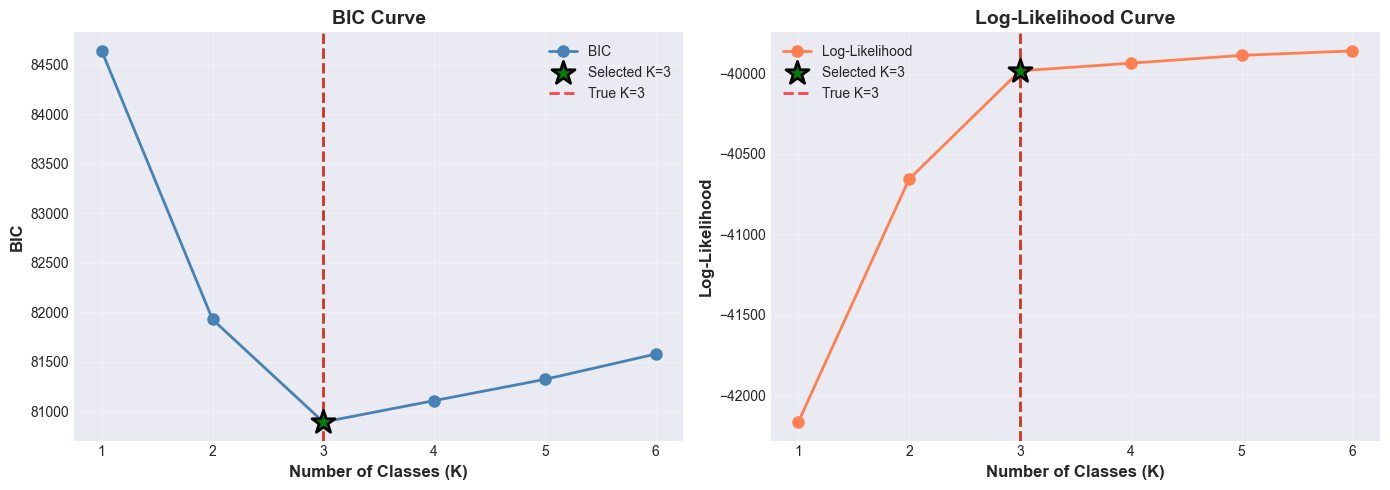

<Figure size 640x480 with 0 Axes>


Interpretation:
- The blue line shows BIC values (lower is better)
- The orange line shows log-likelihood (higher is better)
- The red dashed line marks the selected K
- The green dashed line marks the true K

Notice how log-likelihood always improves with more classes,
but BIC penalizes complexity, leading to an optimal K.


In [7]:
# Plot BIC curve
plot_bic_curve(
    bic_results=results,
    true_K=K_true,
    save_path=None,  # Don't save, display inline
)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- The blue line shows BIC values (lower is better)")
print("- The orange line shows log-likelihood (higher is better)")
print("- The red dashed line marks the selected K")
print("- The green dashed line marks the true K")
print("\nNotice how log-likelihood always improves with more classes,")
print("but BIC penalizes complexity, leading to an optimal K.")

## Step 3: Analyze the Selected Model

Now we'll analyze the model selected by BIC and compare it to the true model.

### 3.1 Mixture Weights (π)

The mixture weights $\pi_k$ represent the probability that a randomly selected observation belongs to class $k$. Let's compare the estimated mixture weights with the true values.

In [8]:
# Get estimated parameters
estimated_params = selector.get_best_model()
estimated_pi = estimated_params['pi']
estimated_theta = estimated_params['theta']

print("\n" + "="*70)
print("MIXTURE WEIGHTS COMPARISON")
print("="*70)

if selected_K == K_true:
    print(f"\n{'Class':<8} {'True π':<12} {'Estimated π':<12} {'Absolute Error':<15}")
    print("-" * 50)
    
    for k in range(K_true):
        error = abs(true_pi[k] - estimated_pi[k])
        print(f"{k:<8} {true_pi[k]:<12.4f} {estimated_pi[k]:<12.4f} {error:<15.4f}")
    
    # Compute overall error metrics
    mae = np.mean(np.abs(true_pi - estimated_pi))
    rmse = np.sqrt(np.mean((true_pi - estimated_pi)**2))
    
    print(f"\nOverall Metrics:")
    print(f"  Mean Absolute Error (MAE):  {mae:.6f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.6f}")
else:
    print(f"\nCannot compare parameters: K mismatch (selected={selected_K}, true={K_true})")
    print(f"\nEstimated mixture weights (K={selected_K}):")
    for k in range(selected_K):
        print(f"  Class {k}: π_{k} = {estimated_pi[k]:.4f}")


MIXTURE WEIGHTS COMPARISON

Class    True π       Estimated π  Absolute Error 
--------------------------------------------------
0        0.3359       0.3410       0.0051         
1        0.3342       0.3298       0.0044         
2        0.3299       0.3292       0.0007         

Overall Metrics:
  Mean Absolute Error (MAE):  0.003426
  Root Mean Squared Error (RMSE): 0.003939


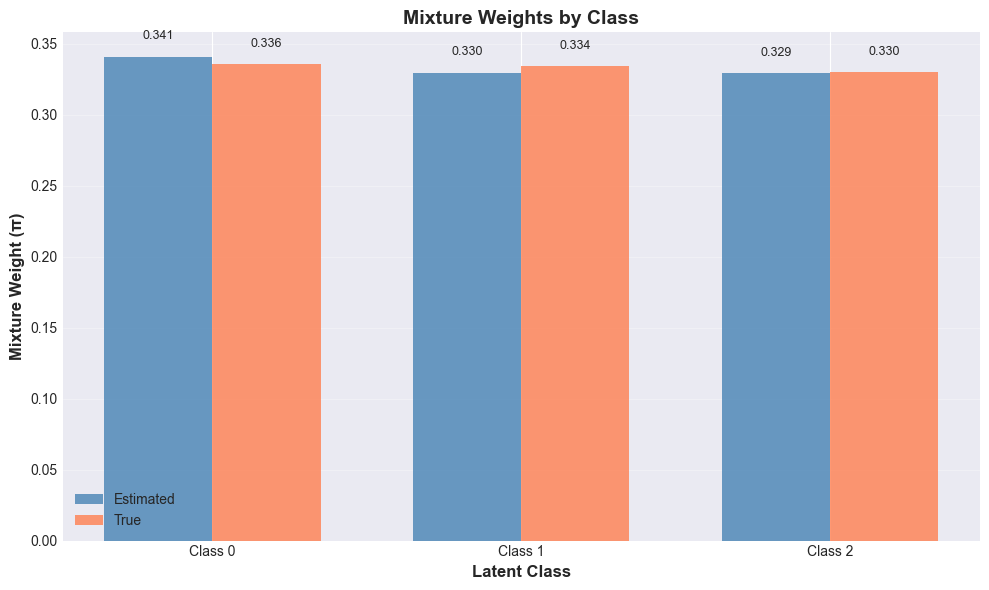

<Figure size 640x480 with 0 Axes>


The plot shows estimated (blue) vs true (orange) mixture weights.
Good parameter recovery is indicated by similar bar heights.


In [9]:
# Visualize mixture weights comparison
if selected_K == K_true:
    plot_mixture_weights(
        pi=estimated_pi,
        true_pi=true_pi,
        save_path=None,
    )
else:
    plot_mixture_weights(
        pi=estimated_pi,
        true_pi=None,
        save_path=None,
    )

plt.tight_layout()
plt.show()

if selected_K == K_true:
    print("\nThe plot shows estimated (blue) vs true (orange) mixture weights.")
    print("Good parameter recovery is indicated by similar bar heights.")
else:
    print("\nThe plot shows estimated mixture weights for the selected model.")

### 3.2 Categorical Probabilities (θ)

The categorical probabilities $\theta_{rkc} = P(X^{(r)} = c | H = k)$ define how each latent class generates observed categories for each variable. Let's visualize these for the first several variables.

In [10]:
if selected_K == K_true:
    # Compute theta errors
    theta_mae = np.mean(np.abs(true_theta - estimated_theta))
    theta_rmse = np.sqrt(np.mean((true_theta - estimated_theta)**2))
    
    print("\n" + "="*70)
    print("CATEGORICAL PROBABILITIES (θ) - ERROR METRICS")
    print("="*70)
    print(f"Mean Absolute Error (MAE):  {theta_mae:.6f}")
    print(f"Root Mean Squared Error (RMSE): {theta_rmse:.6f}")
    
    # Per-class errors
    print(f"\nPer-Class MAE:")
    for k in range(K_true):
        class_mae = np.mean(np.abs(true_theta[k] - estimated_theta[k]))
        print(f"  Class {k}: {class_mae:.6f}")


CATEGORICAL PROBABILITIES (θ) - ERROR METRICS
Mean Absolute Error (MAE):  0.013091
Root Mean Squared Error (RMSE): 0.016334

Per-Class MAE:
  Class 0: 0.013441
  Class 1: 0.012655
  Class 2: 0.013177


### 3.3 Class Assignment Analysis

Now let's evaluate how well the model can classify observations into their true latent classes. We'll use the trained model to predict class assignments and compare them with the true labels.

In [11]:
# Create a new model instance with the selected K and fit it
# (We need this to get predictions)
print("\n" + "="*70)
print("CLASS ASSIGNMENT ANALYSIS")
print("="*70)
print(f"\nFitting model with selected K={selected_K} to get class predictions...\n")

final_model = LatentClassModel(K=selected_K, categories=categories, random_state=42)
final_model.fit(X, max_iter=max_iter, tol=tol, n_init=n_init, n_jobs=-1, verbose=False)

# Get predictions
predicted_classes = final_model.predict(X)
posterior_probs = final_model.predict_proba(X)

print(f"Model converged: {final_model.converged}")
print(f"Number of iterations: {final_model.n_iterations}")
print(f"Final log-likelihood: {final_model.best_log_likelihood:.2f}")


CLASS ASSIGNMENT ANALYSIS

Fitting model with selected K=3 to get class predictions...

Model converged: True
Number of iterations: 37
Final log-likelihood: -39983.08


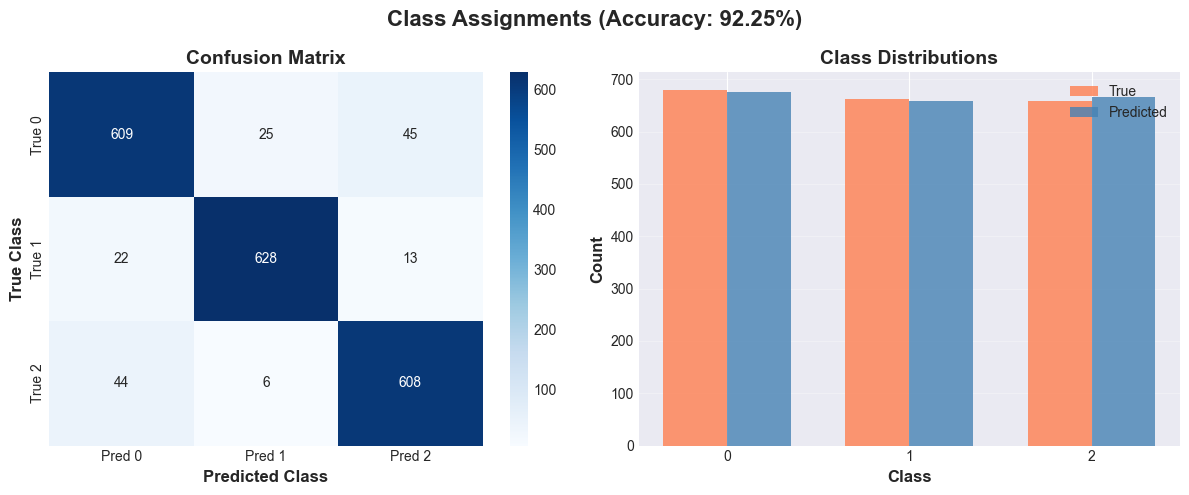


Classification Accuracy (after optimal label matching): 0.9225

This means 92.25% of observations were correctly classified
into their true latent class.

Per-Class Precision:
  Class 0: 0.9022
  Class 1: 0.9530
  Class 2: 0.9129

Per-Class Recall:
  Class 0: 0.8969
  Class 1: 0.9472
  Class 2: 0.9240


In [12]:
if selected_K == K_true:
    # Visualize confusion matrix
    fig = plot_class_assignments(
        true_labels=H,
        predicted_labels=predicted_classes,
        save_path=None
    )
    plt.show()
    
    # Compute classification accuracy
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix, accuracy_score
    
    # Create confusion matrix
    cm = confusion_matrix(H, predicted_classes)
    
    # Find optimal label matching (Hungarian algorithm)
    # Maximize the trace by minimizing the negative
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    # Remap predicted labels
    label_mapping = dict(zip(col_ind, row_ind))
    remapped_predictions = np.array([label_mapping[p] for p in predicted_classes])
    
    # Compute accuracy
    accuracy = accuracy_score(H, remapped_predictions)
    
    print(f"\nClassification Accuracy (after optimal label matching): {accuracy:.4f}")
    print(f"\nThis means {accuracy*100:.2f}% of observations were correctly classified")
    print("into their true latent class.")
    
    # Per-class metrics
    print(f"\nPer-Class Precision:")
    cm_remapped = confusion_matrix(H, remapped_predictions)
    for k in range(K_true):
        precision = cm_remapped[k, k] / cm_remapped[:, k].sum() if cm_remapped[:, k].sum() > 0 else 0
        print(f"  Class {k}: {precision:.4f}")
    
    print(f"\nPer-Class Recall:")
    for k in range(K_true):
        recall = cm_remapped[k, k] / cm_remapped[k, :].sum() if cm_remapped[k, :].sum() > 0 else 0
        print(f"  Class {k}: {recall:.4f}")
else:
    print(f"\nCannot compute classification accuracy: K mismatch (selected={selected_K}, true={K_true})")
    print(f"\nDistribution of predicted classes:")
    for k in range(selected_K):
        count = np.sum(predicted_classes == k)
        proportion = count / n
        print(f"  Class {k}: {count} samples ({proportion:.1%})")

### 3.4 Posterior Probability Analysis

The posterior probabilities $P(H_i=k | X_i)$ tell us how confident the model is about each observation's class assignment. Let's analyze the uncertainty in class assignments.

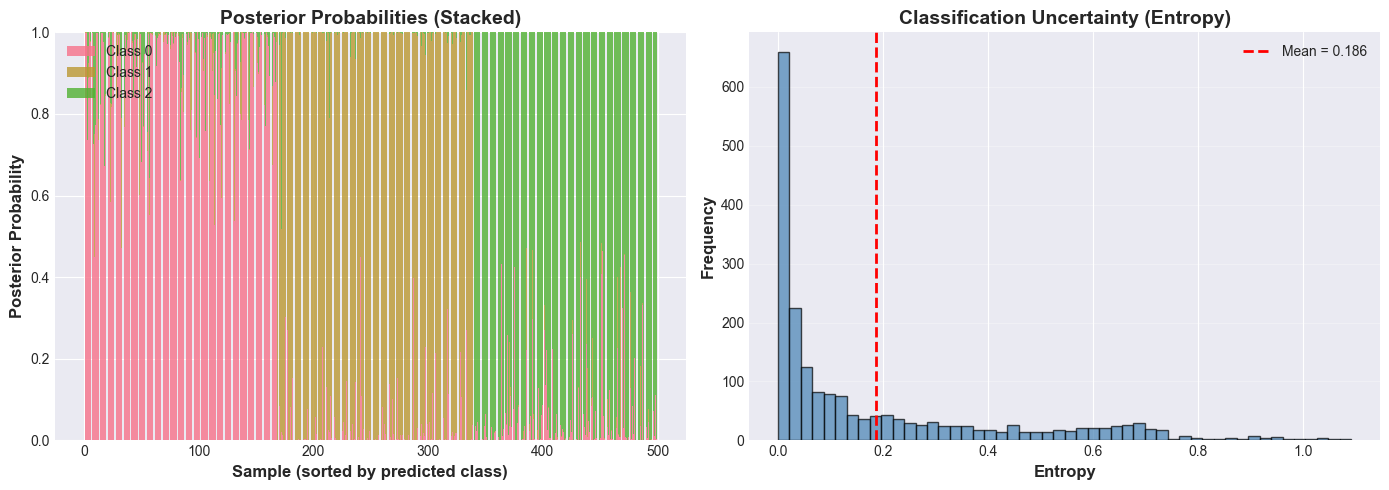


POSTERIOR PROBABILITY STATISTICS

Maximum posterior probability:
  Mean:   0.9296
  Median: 0.9886
  Min:    0.3618
  Max:    1.0000

Posterior entropy (uncertainty):
  Mean:   0.1858
  Median: 0.0636

Confidence distribution:
  High confidence (max prob > 0.9): 78.5%
  Low confidence (max prob < 0.5):  0.8%

Interpretation:
- Higher maximum probabilities indicate more confident classifications
- Lower entropy indicates less uncertainty in class assignments
- 78.5% of observations have very clear class membership


In [13]:
# Visualize posterior probabilities
fig = plot_posterior_uncertainty(
    gamma=posterior_probs,
    predicted_labels=predicted_classes,
    save_path=None
)
plt.show()

# Compute statistics on posterior probabilities
max_probs = np.max(posterior_probs, axis=1)
entropy = -np.sum(posterior_probs * np.log(posterior_probs + 1e-10), axis=1)

print("\n" + "="*70)
print("POSTERIOR PROBABILITY STATISTICS")
print("="*70)
print(f"\nMaximum posterior probability:")
print(f"  Mean:   {np.mean(max_probs):.4f}")
print(f"  Median: {np.median(max_probs):.4f}")
print(f"  Min:    {np.min(max_probs):.4f}")
print(f"  Max:    {np.max(max_probs):.4f}")

print(f"\nPosterior entropy (uncertainty):")
print(f"  Mean:   {np.mean(entropy):.4f}")
print(f"  Median: {np.median(entropy):.4f}")

# Count high-confidence predictions
high_confidence = np.sum(max_probs > 0.9) / n
low_confidence = np.sum(max_probs < 0.5) / n

print(f"\nConfidence distribution:")
print(f"  High confidence (max prob > 0.9): {high_confidence:.1%}")
print(f"  Low confidence (max prob < 0.5):  {low_confidence:.1%}")

print(f"\nInterpretation:")
print(f"- Higher maximum probabilities indicate more confident classifications")
print(f"- Lower entropy indicates less uncertainty in class assignments")
print(f"- {high_confidence*100:.1f}% of observations have very clear class membership")

## Step 4: Summary and Conclusions

Let's summarize the key findings from this analysis.

In [14]:
print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

print(f"\n📊 Data Configuration:")
print(f"   - Sample size: {n}")
print(f"   - True number of classes: {K_true}")
print(f"   - Number of variables: {m}")
print(f"   - Categories per variable: {C}")

print(f"\n🔍 Model Selection:")
print(f"   - K values tested: {K_range}")
print(f"   - Selected K: {selected_K}")
print(f"   - Selection correct: {'✓ YES' if selected_K == K_true else '✗ NO'}")

if selected_K == K_true:
    print(f"\n📈 Parameter Recovery:")
    print(f"   - Mixture weights MAE: {mae:.6f}")
    print(f"   - Mixture weights RMSE: {rmse:.6f}")
    print(f"   - Categorical probabilities MAE: {theta_mae:.6f}")
    print(f"   - Categorical probabilities RMSE: {theta_rmse:.6f}")
    
    print(f"\n🎯 Classification Performance:")
    print(f"   - Overall accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   - High confidence predictions: {high_confidence:.1%}")
    print(f"   - Mean maximum posterior prob: {np.mean(max_probs):.4f}")

print(f"\n⚙️  Algorithm Performance:")
print(f"   - Converged: {final_model.converged}")
print(f"   - Iterations: {final_model.n_iterations}")
print(f"   - Final log-likelihood: {final_model.best_log_likelihood:.2f}")

print("\n" + "="*70)
print("KEY TAKEAWAYS")
print("="*70)

if selected_K == K_true:
    print("\n✓ The BIC criterion successfully identified the correct number of classes.")
    print("\n✓ Parameter estimates closely match the true values, demonstrating")
    print("  effective parameter recovery with the EM algorithm.")
    print(f"\n✓ The model achieves {accuracy*100:.1f}% classification accuracy, indicating")
    print("  strong ability to recover latent class structure from observed data.")
    print(f"\n✓ {high_confidence*100:.1f}% of observations have highly confident class assignments")
    print("  (posterior probability > 0.9), suggesting clear separation between classes.")
else:
    print(f"\n⚠️  The BIC criterion selected K={selected_K} instead of true K={K_true}.")
    print("\n   This could be due to:")
    print("   - Limited sample size relative to model complexity")
    print("   - Weak separation between some latent classes")
    print("   - Random variation in this particular dataset")
    print("\n   Consider:")
    print("   - Increasing sample size (n)")
    print("   - Running multiple replications to assess stability")
    print("   - Examining the BIC curve for near-optimal solutions")

print("\n" + "="*70)
print("END OF DEMO")
print("="*70)


EXPERIMENT SUMMARY

📊 Data Configuration:
   - Sample size: 2000
   - True number of classes: 3
   - Number of variables: 20
   - Categories per variable: 3

🔍 Model Selection:
   - K values tested: [1, 2, 3, 4, 5, 6]
   - Selected K: 3
   - Selection correct: ✓ YES

📈 Parameter Recovery:
   - Mixture weights MAE: 0.003426
   - Mixture weights RMSE: 0.003939
   - Categorical probabilities MAE: 0.013091
   - Categorical probabilities RMSE: 0.016334

🎯 Classification Performance:
   - Overall accuracy: 0.9225 (92.25%)
   - High confidence predictions: 78.5%
   - Mean maximum posterior prob: 0.9296

⚙️  Algorithm Performance:
   - Converged: True
   - Iterations: 37
   - Final log-likelihood: -39983.08

KEY TAKEAWAYS

✓ The BIC criterion successfully identified the correct number of classes.

✓ Parameter estimates closely match the true values, demonstrating
  effective parameter recovery with the EM algorithm.

✓ The model achieves 92.2% classification accuracy, indicating
  strong abil